In [5]:
# Cell 1: Imports and Setup
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import CSVLogger
import shutil

from model_brain import BrainTumorConvNet, BrainTumorDeepConvNet

print("Imports complete!")

Imports complete!


In [6]:
# Cell 2: CleanImageFolder and Data Setup

class CleanImageFolder(ImageFolder):
    """Filters out .ipynb_checkpoints folders"""
    def find_classes(self, directory):
        classes, class_to_idx = super().find_classes(directory)
        if ".ipynb_checkpoints" in classes:
            classes.remove(".ipynb_checkpoints")
            class_to_idx = {c: i for i, c in enumerate(classes)}
        return classes, class_to_idx

# Paths
data_dir = "data/Brain_MRI_Images/Train"
val_dir = "data/Brain_MRI_Images/Validation"

# Transform
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = CleanImageFolder(root=data_dir, transform=transform)
val_dataset = CleanImageFolder(root=val_dir, transform=transform)

num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes} | num_classes = {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Classes: ['Normal', 'Tumor'] | num_classes = 2
Training samples: 320
Validation samples: 80


In [7]:
# Cell 3: Create DataLoaders

batch_size = 32

# Split training for test set (85% train, 15% test)
train_size = int(0.85 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_data, test_data = random_split(
    train_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Device: cpu
Train batches: 9, Val batches: 3, Test batches: 2


In [8]:
# Cell 4: Training Function

def train_model(model, train_loader, val_loader, model_name: str, max_epochs: int = 10):
    # Clean old logs
    shutil.rmtree(f"./lightning_logs/{model_name}", ignore_errors=True)
    
    seed_everything(0, workers=True)
    logger = CSVLogger("./lightning_logs", name=model_name)
    
    trainer = Trainer(
        max_epochs=max_epochs,
        logger=logger,
        deterministic=True,
        accelerator="auto",
        devices=1
    )
    
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    # Save weights
    torch.save(model.state_dict(), f"{model_name}.pth")
    
    # Test
    test_results = trainer.test(model, dataloaders=test_loader)
    print(f"Test results for {model_name}: {test_results}")
    
    return model_name

print("Training function defined!")

Training function defined!


In [9]:
# Cell 5: Train the Deep Model
# (Run this cell to start training - takes a few minutes)

deep_model = BrainTumorDeepConvNet(num_classes=num_classes)
model_name = train_model(
    model=deep_model,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="BrainTumorDeepConvNet",
    max_epochs=10
)

Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs/BrainTumorDeepConvNet

  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 8.5 M 
------------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params
33.931    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_step_acc       │    0.7916666865348816     │
│      test_step_loss       │     0.500873327255249     │
└───────────────────────────┴───────────────────────────┘

Test results for BrainTumorDeepConvNet: [{'test_step_acc': 0.7916666865348816, 'test_step_loss': 0.500873327255249}]


In [10]:
# Cell 6: Analyze Metrics CSV
# (Run this AFTER training completes)

def analyze_metrics(model_name: str):
    metrics_path = f"./lightning_logs/{model_name}/version_0/metrics.csv"
    
    if not os.path.exists(metrics_path):
        print(f"Metrics file not found at {metrics_path}")
        return None
    
    df = pd.read_csv(metrics_path)
    print(f"\n=== Metrics for {model_name} ===")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Total rows: {len(df)}")
    
    return df

# Load and display metrics
df = analyze_metrics("BrainTumorDeepConvNet")
if df is not None:
    display(df.head(20))


=== Metrics for BrainTumorDeepConvNet ===
Columns: ['step', 'val_step_loss', 'epoch', 'val_step_acc', 'train_step_loss', 'train_step_acc', 'test_step_acc', 'test_step_loss']
Total rows: 12


,step,val_step_loss,epoch,val_step_acc,train_step_loss,train_step_acc,test_step_acc,test_step_loss
0,8,0.675662,0,0.539773,NaN,NaN,NaN,NaN
1,17,0.655939,1,0.571023,NaN,NaN,NaN,NaN
2,26,0.633167,2,0.653409,NaN,NaN,NaN,NaN
3,35,0.609325,3,0.650568,NaN,NaN,NaN,NaN
4,44,0.522620,4,0.750000,NaN,NaN,NaN,NaN
5,49,NaN,5,NaN,0.42336,0.78125,NaN,NaN
6,53,0.593609,5,0.764205,NaN,NaN,NaN,NaN
7,62,0.518184,6,0.809659,NaN,NaN,NaN,NaN
8,71,0.454325,7,0.843750,NaN,NaN,NaN,NaN
9,80,0.455008,8,0.829545,NaN,NaN,NaN,NaN


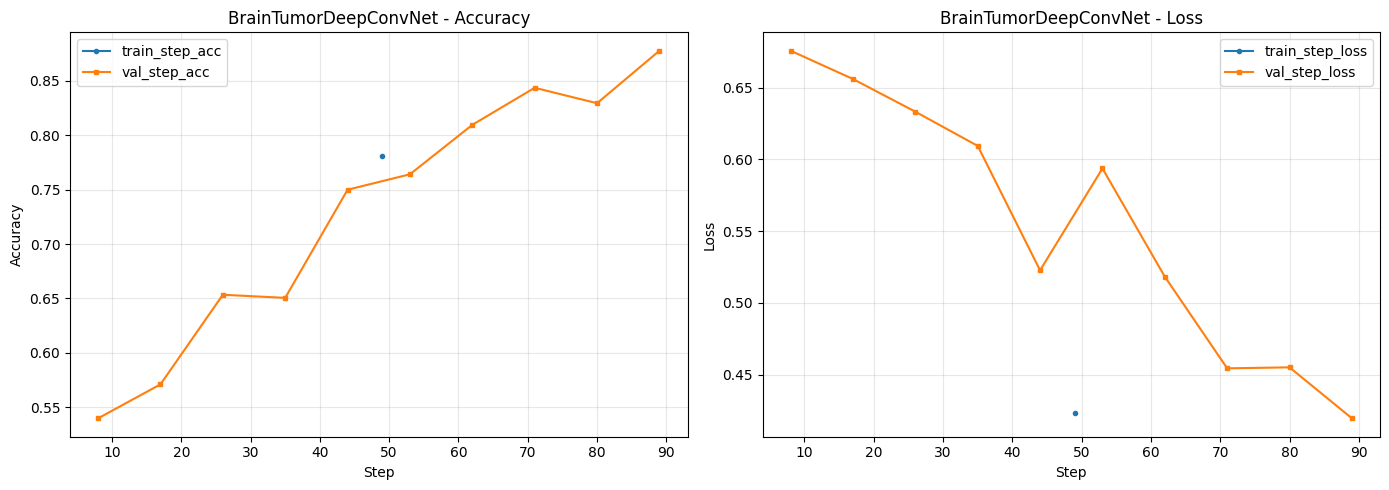


=== Final Validation Accuracy ===
      val_step_acc
step              
53        0.764205
62        0.809659
71        0.843750
80        0.829545
89        0.877841


In [11]:
# Cell 7: Plot Training & Validation Accuracy

def plot_metrics(model_name: str):
    metrics_path = f"./lightning_logs/{model_name}/version_0/metrics.csv"
    
    if not os.path.exists(metrics_path):
        print(f"Metrics file not found!")
        return
    
    df = pd.read_csv(metrics_path)
    df.set_index("step", inplace=True)
    
    # Plot accuracies
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    ax1 = axes[0]
    df[['train_step_acc']].dropna().plot(ax=ax1, label='Train Acc', marker='o', markersize=3)
    df[['val_step_acc']].dropna().plot(ax=ax1, label='Val Acc', marker='s', markersize=3)
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"{model_name} - Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2 = axes[1]
    df[['train_step_loss']].dropna().plot(ax=ax2, label='Train Loss', marker='o', markersize=3)
    df[['val_step_loss']].dropna().plot(ax=ax2, label='Val Loss', marker='s', markersize=3)
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.set_title(f"{model_name} - Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\n=== Final Validation Accuracy ===")
    val_acc = df[['val_step_acc']].dropna()
    print(val_acc.tail())

plot_metrics("BrainTumorDeepConvNet")